This notebook shows how to preprocess and explore the dataset, finally creating k-folds for experiments.

# Imports

We will use the following libraries:
- **Pandas**, **NumPy**: data manipulation & analysis libraries ([documentation](https://pandas.pydata.org/docs/reference/index.html), [documentation](https://numpy.org/doc/stable/reference/)) - *for efficient data reading/manipulation*
- **Scikit-learn**: a machine learning library ([documentation](https://scikit-learn.org/stable/modules/classes.html)) - *here, for data splitting*
- **Matplotlib**: a visualization library ([documentation](https://matplotlib.org/stable/api/index.html)) - *for making plots about our data*
- Other standard python libraries such as **re** ([documentation](https://docs.python.org/3/library/re.html)) - *for matching sensible data for anonymization*

In [ ]:
# Import the needed libraries (and their functions)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
from sklearn.model_selection import StratifiedKFold

# Set the random seed
RANDOM_SEED = 42

# Load the dataset

We here load the dataset and subset it to match our experimental setup.

## Full dataset reading

First, we load the full dataset, including non-annotated tweets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the filepath to your dataset file
DATASET_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/raw/dataset-en.tsv"

# Load the (tab-separated: \t) dataset into a pandas dataframe
import csv
full_dataset = pd.read_csv(DATASET_FILEPATH, delimiter='\t', quoting=csv.QUOTE_NONE)

full_dataset.head(5)  # print the first 5 elements just for seeing the data

,id,date,level1,level2,level3,level4,level5,text
0,1387264156101840898,2021-04-28T04:35:23.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,"a new commandment i give unto you, that ye lov..."
1,1382309523851923457,2021-04-14T12:27:27.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,#pc4nm #bibleverse but he that is greatest amo...
2,1334176621796835328,2020-12-02T16:44:29.000Z,ABUSIVE,GROUP,RELIGIOUS HATE,ANTI-ISLAM,DEROGATION AND DEHUMANIZATION,cosmos graphically show with audiovisual why s...
3,1338387353732308993,2020-12-14T07:36:25.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,[USER] [USER] [USER] #wahhabism is the false h...
4,1337976598717489153,2020-12-13T04:24:14.000Z,NOT ABUSIVE,NaN,NaN,NaN,NaN,no thanks. this #preacherskid will always want...


## Dataset subsetting

We then subset data to contain annotated tweets only.

In [ ]:
# Create a new dataframe "dataset" containing all the rows having a non-NaN "level1" column value
dataset = full_dataset[full_dataset["level1"].isnull()==False]

# Remove unnecessary columns for these experiments from the resulting dataframe
dataset = dataset.drop(
    columns=["id", "date", "level1", "level2", "level4", "level5"])

# Convert "NaN" values to empty strings to make string operations work
dataset["level3"] = dataset["level3"].fillna('')

# Rename header columns: level3 -> label; text -> tweet
dataset = dataset.rename(columns={'level3': 'label', 'text': 'tweet'})
dataset.reset_index()

# Function used to decide which (religion-related) binary label to assign to the example
def is_religious_hate(data):
  if ('RELIGIOUS' in data['label']):
    return "RELIGIOUS HATE"
  else:
    return "NOT RELIGIOUS HATE"

# Overwrite the label (level3) column with the religious hate label
dataset['label'] = dataset.apply(is_religious_hate, axis=1)

dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet
0,NOT RELIGIOUS HATE,"a new commandment i give unto you, that ye lov..."
1,NOT RELIGIOUS HATE,#pc4nm #bibleverse but he that is greatest amo...
2,RELIGIOUS HATE,cosmos graphically show with audiovisual why s...
3,NOT RELIGIOUS HATE,[USER] [USER] [USER] #wahhabism is the false h...
4,NOT RELIGIOUS HATE,no thanks. this #preacherskid will always want...
5,RELIGIOUS HATE,[USER] .....when i worked out that some of the...
6,NOT RELIGIOUS HATE,short story | the bond between hindus &amp; mu...
7,NOT RELIGIOUS HATE,[URL] this is so heartbreaking :(
8,NOT RELIGIOUS HATE,"he is not here: for he is risen, as he said. c..."
9,NOT RELIGIOUS HATE,[USER] [USER] the catholic communion (eucharis...


In [ ]:
# Check the resulting number of annotated tweets in the dataset
print(dataset.shape)  # first value is #rows (tweets), second value is #cols

(7028, 2)


# Preprocess the dataset

Before using our data, there are some preprocessing steps we need to do. These are outlined in the following.

## Data cleaning

We create a new column with a cleaned version of the tweets, namely all lowercased, without special newline / non-standard characters.

In [ ]:
# Define the function that will do the cleaning
# Note: a function is informally a "general and reusable piece of code"
def clean_tweet(text):
  text = text.lower()                   # convert the text to lowercase
  text = text.replace("\n", " ")        # remove newline characters
  text = text.replace("\r", " ")        # remove newline characters (as above, but different encoding)
  text = text.replace(u'\xa0', u' ')    # remove non-standard characters (no-break space)
  text = text.replace(u'\u200d', u' ')  # remove non-standard characters (zero-width joiner)
  return text

# Do the actual cleaning on the "tweet" column of the dataframe
# Then convert the results to a list and put them on a new "tweet_preprocessed" column
dataset['tweet_preprocessed'] = list(map(clean_tweet, dataset.tweet))
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
0,NOT RELIGIOUS HATE,"a new commandment i give unto you, that ye lov...","a new commandment i give unto you, that ye lov..."
1,NOT RELIGIOUS HATE,#pc4nm #bibleverse but he that is greatest amo...,#pc4nm #bibleverse but he that is greatest amo...
2,RELIGIOUS HATE,cosmos graphically show with audiovisual why s...,cosmos graphically show with audiovisual why s...
3,NOT RELIGIOUS HATE,[USER] [USER] [USER] #wahhabism is the false h...,[user] [user] [user] #wahhabism is the false h...
4,NOT RELIGIOUS HATE,no thanks. this #preacherskid will always want...,no thanks. this #preacherskid will always want...
5,RELIGIOUS HATE,[USER] .....when i worked out that some of the...,[user] .....when i worked out that some of the...
6,NOT RELIGIOUS HATE,short story | the bond between hindus &amp; mu...,short story | the bond between hindus &amp; mu...
7,NOT RELIGIOUS HATE,[URL] this is so heartbreaking :(,[url] this is so heartbreaking :(
8,NOT RELIGIOUS HATE,"he is not here: for he is risen, as he said. c...","he is not here: for he is risen, as he said. c..."
9,NOT RELIGIOUS HATE,[USER] [USER] the catholic communion (eucharis...,[user] [user] the catholic communion (eucharis...


## Data anonymization

Tweets contain sensitive information (e.g., user mentions, URLs). We want to avoid keeping those for the following main reasons:
- It is a concern for privacy reasons and EU regulations;
- A model should not learn sensitive information about users and generalize based on that;
- Highly frequent user mentions or URLs would lead to undesidered biases / overfitting to spurious lexical items.

In [ ]:
# Define the function that will do the match and replacement
def anonymize_tweet(text):
  text = text.replace("[user]", "[USER]")
  text = text.replace("[url]", "[URL]")
  return text

# Do the actual match and replacement on the "tweet_preprocessed" column of the dataframe
# We are actually overwriting the column created before with a further refined preprocessed version (i.e., anonymized)
dataset['tweet_preprocessed'] = list(map(anonymize_tweet, dataset.tweet_preprocessed))
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
0,NOT RELIGIOUS HATE,"a new commandment i give unto you, that ye lov...","a new commandment i give unto you, that ye lov..."
1,NOT RELIGIOUS HATE,#pc4nm #bibleverse but he that is greatest amo...,#pc4nm #bibleverse but he that is greatest amo...
2,RELIGIOUS HATE,cosmos graphically show with audiovisual why s...,cosmos graphically show with audiovisual why s...
3,NOT RELIGIOUS HATE,[USER] [USER] [USER] #wahhabism is the false h...,[USER] [USER] [USER] #wahhabism is the false h...
4,NOT RELIGIOUS HATE,no thanks. this #preacherskid will always want...,no thanks. this #preacherskid will always want...
5,RELIGIOUS HATE,[USER] .....when i worked out that some of the...,[USER] .....when i worked out that some of the...
6,NOT RELIGIOUS HATE,short story | the bond between hindus &amp; mu...,short story | the bond between hindus &amp; mu...
7,NOT RELIGIOUS HATE,[URL] this is so heartbreaking :(,[URL] this is so heartbreaking :(
8,NOT RELIGIOUS HATE,"he is not here: for he is risen, as he said. c...","he is not here: for he is risen, as he said. c..."
9,NOT RELIGIOUS HATE,[USER] [USER] the catholic communion (eucharis...,[USER] [USER] the catholic communion (eucharis...


## Data deduplication

The presence of duplicates could lead to biases and unrealiable analyses and results. 

In our dataset we don't have any; however, we here show how to do this step for illustration purposes.

In [ ]:
# Remove duplicates based on the "tweet_preprocessed" column
#dataset.drop_duplicates(subset={"tweet_preprocessed"}, inplace=True)
#print(dataset.shape)  # first value is #rows (tweets), second value is #cols

# Explore the dataset

Getting into data before delving into more complex modeling decisions is crucial to understand what we are manipulating.

### Summary statistics

We notice the dataset is quite unbalanced; we can thus hypothesize that the underrepresented class(es) will be more difficult to predict.

Tot examples: 7028
NOT RELIGIOUS HATE    6365
RELIGIOUS HATE         663
Name: label, dtype: int64



Text(0, 0.5, 'Count')

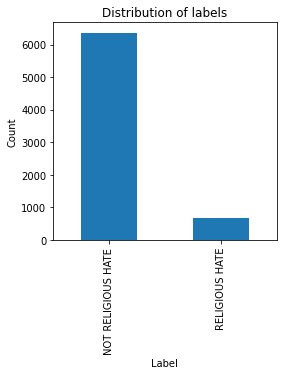

In [ ]:
tot_examples = dataset.shape[0]           # rows (first element) are number of examples
print(f"Tot examples: {tot_examples}")    # total number of examples
print(dataset["label"].value_counts())    # number of tweets per label
print()

# Plot the distribution of labels
ax = dataset["label"].value_counts().plot(kind='bar', figsize=(4,4))
fig = ax.get_figure()
ax.set_title("Distribution of labels")
ax.set_xlabel('Label')
ax.set_ylabel('Count')

# Create data splits

To run experiments, we need to split our dataset into training and test sets:
- **training set**: used for fitting the model (this is the largest split);
- **test set**: used for final performance evaluation of our model.

Using a single train/test split for evaluation is typically not enough, especially when the dataset is quite small. Indeed, the test portion may not be representative of the entire dataset. **K-fold cross-validation** is typically preferred (see [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation)). We will use its **stratified** version.

In [ ]:
# First, shuffle the rows in the dataset. This will avoid undesirable ordered splits
dataset = dataset.sample(frac=1, random_state=RANDOM_SEED)
dataset.head(10)  # print the first 10 elements just for seeing the data

,label,tweet,tweet_preprocessed
2476,NOT RELIGIOUS HATE,[USER] [USER] [USER] pray? don’t pray not cath...,[USER] [USER] [USER] pray? don’t pray not cath...
6769,NOT RELIGIOUS HATE,i feel like europeans strongly felt people sho...,i feel like europeans strongly felt people sho...
4635,NOT RELIGIOUS HATE,i love the way muslims behave some at times mo...,i love the way muslims behave some at times mo...
3047,NOT RELIGIOUS HATE,[USER] [USER] [USER] exactly. the “good” chris...,[USER] [USER] [USER] exactly. the “good” chris...
4092,NOT RELIGIOUS HATE,[USER] you shall have no other gods before me....,[USER] you shall have no other gods before me....
3218,NOT RELIGIOUS HATE,"[USER] [USER] [USER] [USER] [USER] [USER] yup,...","[USER] [USER] [USER] [USER] [USER] [USER] yup,..."
3768,RELIGIOUS HATE,general dostum is a thief-in-chief like [USER]...,general dostum is a thief-in-chief like [USER]...
3463,NOT RELIGIOUS HATE,#afghanistan #indianmuslims #crossborn #afghan...,#afghanistan #indianmuslims #crossborn #afghan...
3414,NOT RELIGIOUS HATE,[USER] [USER] there must be a difference of op...,[USER] [USER] there must be a difference of op...
1192,NOT RELIGIOUS HATE,8mm white &amp; gold cloisonne' bead catholic ...,8mm white &amp; gold cloisonne' bead catholic ...


In [ ]:
# Then, create K train/test set pairs
# The output will be stored on the data/ folder

# Create a list of texts and labels as numpy arrays
tweets_list = np.array(dataset["tweet_preprocessed"])
labels_list = np.array(dataset["label"])
X = np.array(tweets_list)
y = np.array(labels_list)

# Create the stratified k-fold cross-validator object (5 splits)
kf_object = StratifiedKFold(n_splits=5)

# Iterate over the 5 resulting folds' train/test indices
split_number = 1  # a counter for splits
for train_indices, test_indices in kf_object.split(X, y):
  # Subset the original dataset according to the indices
  curr_train = dataset.iloc[train_indices]
  curr_test = dataset.iloc[test_indices]

  # Remove unnecessary columns
  curr_train = curr_train.drop(columns=["tweet"])
  curr_test = curr_test.drop(columns=["tweet"])

  # Print statistics of the current split (#split_number)
  print(f"Split number: {split_number}.")
  print(f"- Train examples:          {curr_train.shape[0]}")
  print(f"  - RELIGIOUS HATE instances:      {curr_train['label'].value_counts()['RELIGIOUS HATE']}")
  print(f"  - NOT RELIGIOUS HATE instances:  {curr_train['label'].value_counts()['NOT RELIGIOUS HATE']}")
  print(f"- Test examples:            {curr_test.shape[0]}")
  print(f"  - RELIGIOUS HATE instances:       {curr_test['label'].value_counts()['RELIGIOUS HATE']}")
  print(f"  - NOT RELIGIOUS HATE instances:  {curr_test['label'].value_counts()['NOT RELIGIOUS HATE']}")
  print()

  # Define the train e test filepaths for the current split
  TRAIN_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/religious/train-en_" + str(split_number) + ".tsv"
  TEST_FILEPATH = "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/religious/test-en_" + str(split_number) + ".tsv"

  # Save the splits as tsv files (without header and index)
  curr_train.to_csv(TRAIN_FILEPATH, sep="\t", header=False, index=False)
  curr_test.to_csv(TEST_FILEPATH, sep="\t", header=False, index=False)

  split_number += 1 # increment the counter for splits

Split number: 1.
- Train examples:          5622
  - RELIGIOUS HATE instances:      530
  - NOT RELIGIOUS HATE instances:  5092
- Test examples:            1406
  - RELIGIOUS HATE instances:       133
  - NOT RELIGIOUS HATE instances:  1273

Split number: 2.
- Train examples:          5622
  - RELIGIOUS HATE instances:      530
  - NOT RELIGIOUS HATE instances:  5092
- Test examples:            1406
  - RELIGIOUS HATE instances:       133
  - NOT RELIGIOUS HATE instances:  1273

Split number: 3.
- Train examples:          5622
  - RELIGIOUS HATE instances:      530
  - NOT RELIGIOUS HATE instances:  5092
- Test examples:            1406
  - RELIGIOUS HATE instances:       133
  - NOT RELIGIOUS HATE instances:  1273

Split number: 4.
- Train examples:          5623
  - RELIGIOUS HATE instances:      531
  - NOT RELIGIOUS HATE instances:  5092
- Test examples:            1405
  - RELIGIOUS HATE instances:       132
  - NOT RELIGIOUS HATE instances:  1273

Split number: 5.
- Train example